In [1]:
# get cmip example dataset
from xmip.utils import google_cmip_col
col = google_cmip_col()
cat = col.search(variable_id='pr', table_id='day', source_id='GFDL-ESM4', experiment_id='historical', member_id='r1i1p1f1')
cat

,unique
activity_id,1
institution_id,1
source_id,1
experiment_id,1
member_id,1
table_id,1
variable_id,1
grid_label,1
zstore,1
dcpp_init_year,0


In [2]:
ddict = cat.to_dataset_dict()


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


In [3]:
ds = ddict['CMIP.NOAA-GFDL.GFDL-ESM4.historical.day.gr1']

In [17]:
import xesmf as xe
import xarray as xr
import numpy as np
tg_coords  = xr.Dataset( #grid to interpolate CMIP6 simulations to
        {   "longitude": (["a"], np.arange(0,10), {"units": "degrees_east"}),
            "latitude": (["b"], np.arange(0,10), {"units": "degrees_north"}),})
regridder = xe.Regridder(ds,tg_coords,method='nearest_s2d')
output = regridder(ds)
a = output.isel(time=0).squeeze().pr

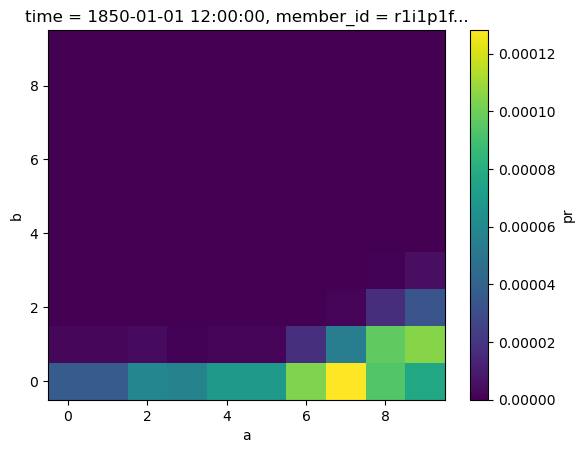

In [18]:
a.plot()

In [19]:
np.diag(a)

array([3.6592563e-05, 2.0317914e-06, 1.8810955e-07, 4.7660916e-12,
       6.0903998e-15, 1.4805888e-16, 9.9563187e-20, 3.4857774e-19,
       1.1665387e-13, 0.0000000e+00], dtype=float32)

It seems to me this is spanning up a domain between 0,10 for each coordinate. I guess what you want from this is the array diagnoal? But honestly I might just do it manually to be really.
Lets confirm this:

In [25]:
tg_coords.isel(a=[0], b=[0])

<xarray.Dataset>
Dimensions:    (a: 1, b: 1)
Dimensions without coordinates: a, b
Data variables:
    longitude  (a) int64 0
    latitude   (b) int64 0

In [31]:
# Manually loop over each location
datasets = []
for tg in range(len(tg_coords.a)):
    single_tg = tg_coords.isel(a=[tg], b=[tg])
    regridder = xe.Regridder(ds,single_tg, method='nearest_s2d')
    datasets.append(regridder(ds).squeeze())
manual_result = xr.concat(datasets, dim='tg')

In [35]:
manual_result.isel(time=0).pr.load()

<xarray.DataArray 'pr' (tg: 10)>
array([3.6592563e-05, 2.0317914e-06, 1.8810955e-07, 4.7660916e-12,
       6.0903998e-15, 1.4805888e-16, 9.9563187e-20, 3.4857774e-19,
       1.1665387e-13, 0.0000000e+00], dtype=float32)
Coordinates:
    time            object 1850-01-01 12:00:00
    member_id       <U8 'r1i1p1f1'
    dcpp_init_year  float64 nan
Dimensions without coordinates: tg

Ok so this seems to give the same result. Overall both methods seem clunky and not very efficient, but either one might still work sufficiently fast here. 

If this turns out to be slow, I would recommend